<a href="https://colab.research.google.com/github/will-conrad/AOTA-Project/blob/main/AOTA_ECE2700_TERM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AOTA (Asteroid Occultation Timing and Analysis) - ECE 2700 Term Project
### ***Keya Garg, Will Conrad, Zohaib Faisal, Alex Farmer***


An asteroid occultation is an event when an asteroid passes in front of a star. If the brightness of the star is recorded, the sampled data will show the stellar brightness blinks out for the duration of the occultation. Multiple observations of the same star from different locations can create a highly accurate profile of the size and shape of the asteroid. Sampled data from recording devices is often extremely noisy, filled with false positives caused by light-emitting phenomena or weather, and difficult to analyse. *AOTA* aims to identify and characterize recorded occultations while retaining data accuracy.  






# Initialize workspace


In [217]:
#@title Import Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr

In [218]:
#@title Clone source repo
!rm -rf /content/*
! git clone https://github.com/will-conrad/AOTA-Project.git

Cloning into 'AOTA-Project'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 9), reused 22 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 793.12 KiB | 20.34 MiB/s, done.
Resolving deltas: 100% (9/9), done.


### Load helper functions

In [219]:
def scale_to_match(target, tracking, interval):
    start, end
    target = np.array(target)
    tracking = np.array(tracking)

    target_trim = target
    track_trim = tracking

    # target_trim = target[start:end]
    # track_trim = tracking[start:end]
    t_min, t_max = target_trim.min(), target_trim.max()
    s_min, s_max = track_trim.min(), track_trim.max()

    scaled = (tracking - s_min) / (s_max - s_min)  # normalize to [0, 1]
    scaled = scaled * (t_max - t_min) + t_min      # rescale to target's range
    return scaled

In [241]:
def betaFilter(y, beta):
    # return gaussian_filter1d(y, sigma=sigma)
  kernel = np.concatenate([np.ones(beta), -np.ones(beta)])
  return np.convolve(y, kernel, mode='same')

In [221]:
def check_correlation(smooth_targ, smooth_track, pred_interval):
    # Slice to prediction window
    start, end = pred_interval

    # Compute Pearson correlation (on smoothed data)
    r, _ = pearsonr(smooth_targ[start:end], smooth_track[start:end])

    return r

In [222]:
def data_shift_scale(data):
  data_mean = np.mean(data)

  data_scaled = []
  if data_mean > 400:
    digits = len(str(int(data_mean)))
    scale_factor = 1/(10 ** (digits - 3))
    for i in range(len(data)):
      data_scaled.append(data[i] * scale_factor)
    #data_scaled_int = np.round(data_scaled).astype(int)
  else:
    data_scaled = data

  data_scaled_further = []
  data_scaled_max = np.max(data_scaled)
  scale_factor_further = 1

  while data_scaled_max > 500:
    data_scaled_max = data_scaled_max * (1/scale_factor_further)
    scale_factor_further *=2

  for i in range(len(data)):
    data_scaled_further.append(data_scaled[i] * (1/scale_factor_further))
  data_scaled_int = np.round(data_scaled_further).astype(int)


  data_scaled_shifted = []
  data_min = np.min(data_scaled_int)
  #print("min of scaled", data_min)
  if data_min < 5:
    shift = abs(data_min)
    for i in range(len(data)):
      data_scaled_shifted.append(data_scaled_int[i] + shift)
  else:
    shift = data_min
    for i in range(len(data)):
      data_scaled_shifted.append(data_scaled_int[i] - shift)


  return data_scaled_shifted



In [223]:
def identify_interval(data, pred_duration, pred_start, error, start_offset):
  if error >= 0.5*pred_duration:
    if pred_duration < 1:
      error += pred_duration
    else:
      error += 0.5*pred_duration
  elif error >= pred_duration:
    if pred_duration < 1:
      error += 1.5*pred_duration
    else:
      error += pred_duration
  if pred_duration >= 3:
    error += 0.8
  if pred_duration <= 1:
    error += 1
  parsed_times = [np.datetime64("2000-01-01T" + t.strip("[]"), 'ns') for t in data]
  target_time = np.datetime64("2000-01-01T" + pred_start, 'ns')
  time_diffs = np.abs(np.array(parsed_times) - target_time)
  pred_index = np.argmin(time_diffs)
  pair_diffs = np.mean(np.array([parsed_times[2], parsed_times[4], parsed_times[6]]) - np.array([parsed_times[1], parsed_times[3], parsed_times[5]]))
  integration = pair_diffs/ np.timedelta64(1,'s')
  lower_index = int(pred_index - 0.5*pred_duration*(1/integration) - error*(1/integration))
  upper_index = int(pred_index + 0.5*pred_duration*(1/integration) + error*(1/integration))

  return lower_index, upper_index


In [224]:
def piecewise_constant_viterbi(y, R): #y is the noisy data, R is the max value it can be (calculated by data_shift_scale)
    N = len(y) # get the length of y into a variable
    P = 3 #we only need 3 segments
    maxcost = np.sum(np.abs(y)) # getting a maximum cost which is just the sum of the absolute value of every point in y

    trellis = np.full((R, P, N), fill_value=maxcost + 1, dtype=int) # creating a 3d array with the dimensions R,P,N where every value is the maxcost+1 and can only be an int
    prevstate = np.empty((R, P, N), dtype=object) # setting a default previous state array with the same dimensions as above, but with zeros and only objects can be input
    for v in range(R):
        for s in range(P):
            for n in range(N):
                prevstate[v, s, n] = (-1, -1, -1) # setting all previous states to (-1, -1, -1)

    for v in range(R):
        trellis[v, 0, 0] = abs(v - y[0]) # initializing the cost at time 0 and segment 0: cost of starting at eachlevel v

    for n in range(1, N): # for each time step starting from 1
        for s in range(P): # for each segment
            for v in range(R): # for each value
              # O(n^3) yikes
                prev_cost = trellis[v, s, n - 1] # get cost of previous step at the same level and segment
                if prev_cost < maxcost: # only consider if the previous cost is valid
                    cost = prev_cost + abs(v - y[n]) # add cost of observing y[n] if staying at level v
                    if cost < trellis[v, s, n]: # Update if this path gives a lower cost
                        trellis[v, s, n] = cost
                        prevstate[v, s, n] = (v, s, n - 1) # revord that we came from the same level

                if s > 0:
                    for pv in range(R): # loop over all previous value levels
                    # this makes it O(n^4)
                        if pv == v:
                            continue # skip if same value
                        prev_cost = trellis[pv, s - 1, n - 1] # previous cost from different level
                        if prev_cost < maxcost:
                            cost = prev_cost + abs(v - y[n]) # add transition cost
                            if cost < trellis[v, s, n]:
                                trellis[v, s, n] = cost
                                prevstate[v, s, n] = (pv, s - 1, n - 1) # record the transition source
    # all of that is to refine the trellis to include the optimal cost for each state (v,s) at every time (n)

    # find the best final state with minimum cost at the end of the sequence
    min_cost = maxcost + 1
    end_state = (-1, -1) # Default to invalid state
    for s in range(P):
        for v in range(R):
            if trellis[v, s, N - 1] < min_cost:
                min_cost = trellis[v, s, N - 1]
                end_state = (v, s) # save the best ending value and segment

    # reconstruct the optimal path using backtracking
    x = np.zeros(N, dtype=int) # output array for signal
    v, s = end_state
    n = N - 1
    while n >= 0 and (v, s, n) != (-1, -1, -1):
        x[n] = v # assign value v to position n in the output signal
        v, s, n = prevstate[v, s, n] # move to the previous state recorded in prevstate

    return x

In [225]:
def get_steps(y):
    step_vals = []
    for val in y:
        if not step_vals or val != step_vals[-1]:
            step_vals.append(val)
        if len(step_vals) == 3:
            break
    return step_vals if len(step_vals) == 3 else []

In [226]:
def checkPos(y):
    step_values = get_steps(y)
    threshold = (step_values[0] - step_values[1])*.25

    print(threshold)

    if len(step_values) < 3:
        return False

    # First step down, second step up
    if step_values[1] < step_values[0] and step_values[2] > step_values[1]:
        # Third value must return close to first
        return abs(step_values[2] - step_values[0]) <= threshold

    return False

In [227]:
def change_frames(x, y):
    change_frames = []
    for i in range(1, len(y)):
        if y[i] != y[i - 1]:
          change_frames.append(x[i])
    return change_frames

In [228]:
def getTimes(frames, times):
  return [
      times[frames[0]], times[frames[1]]
  ]

# STEP 1: Choose data file from annotated source files

In [229]:
# @title Choose file
input = "20241210_888_Parysatis_Garg_POS" # @param ["20241020_3122_Florence_Foote_NEG", "20241109_22027_1999_XS120_Garg_NEG", "20241121_334053_2001_OY11_Oakey_NEG", "20241210_888_Parysatis_Garg_POS", "20250121_70905_1999_VF185_Oakey_POS", "20250218_239829_2001_LH18_Oakey_NEG", "20250227_14203_Hocking_Oakey_POS", "20250227_69794_1998_QM104_Oakey_NEG", "20250303_93_Minerva_Oakey_NEG", "20250318_468861_2013_LU28_Garg_POS", "20250318_468861_2013_LU28_Oakey_POS", "20250410_488_Kruesa_Oakey_POS", "hubble_optics_20241008_214508_AF84_Garg_NEG", "hubble_optics_20241026_208385_2001_SB130_Garg_NEG"]
file_path = "/content/AOTA-Project/Annotated Data/" + input + ".csv"

# Extract data
file = pd.read_csv(file_path, header=None)

# Extract annotations
predicted_time = float(file[1][0])
predicted_error = float(file[1][1])
predicted_start = file[1][2]

notes = file[1][3]

print(notes)
print(predicted_error)
print(predicted_start)
print(predicted_time)

data = pd.read_csv(file_path, skiprows = 4)
print(data)


#Load columns into lists for processing
x_orig = data.iloc[:, 0].tolist()
t_orig = data.iloc[:, 1].tolist()
y_orig = data.iloc[:, 2].tolist()
track1_orig = data.iloc[:, 3].tolist() #change column name as needed

start_offset = x_orig[0]


override = False

none
0.5
04:22:42
6.0
      FrameNum            timeInfo  signal-target  signal-track1
0            0  [04:21:42.3431267]        1110109          98394
1            1  [04:21:42.3933928]        1105439          93707
2            2  [04:21:42.4432419]        1115053          91056
3            3  [04:21:42.4949386]        1088963          94641
4            4  [04:21:42.5433415]        1084104          97265
...        ...                 ...            ...            ...
2392      2392  [04:23:42.1254035]        1182274         102815
2393      2393  [04:23:42.1752961]        1140370          97068
2394      2394  [04:23:42.2254070]        1121889         100602
2395      2395  [04:23:42.2754910]        1113465          99537
2396      2396  [04:23:42.3257144]        1129928         100777

[2397 rows x 4 columns]


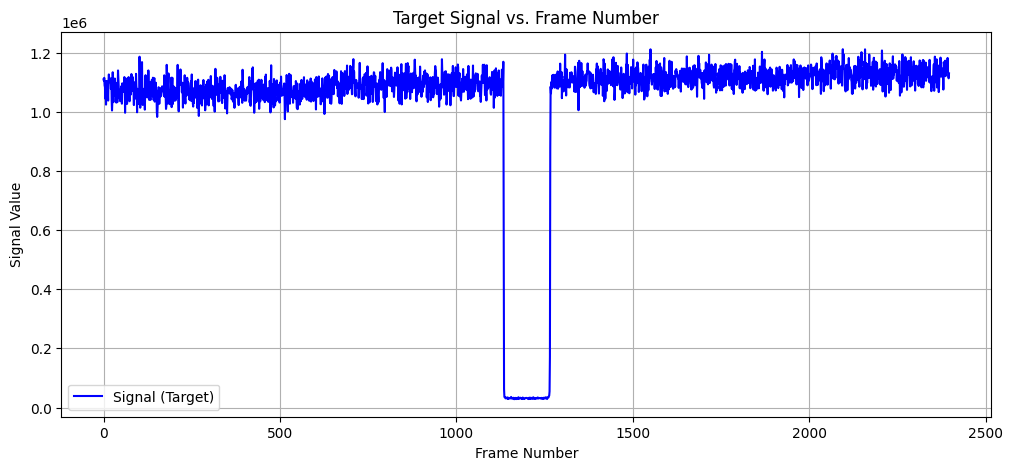

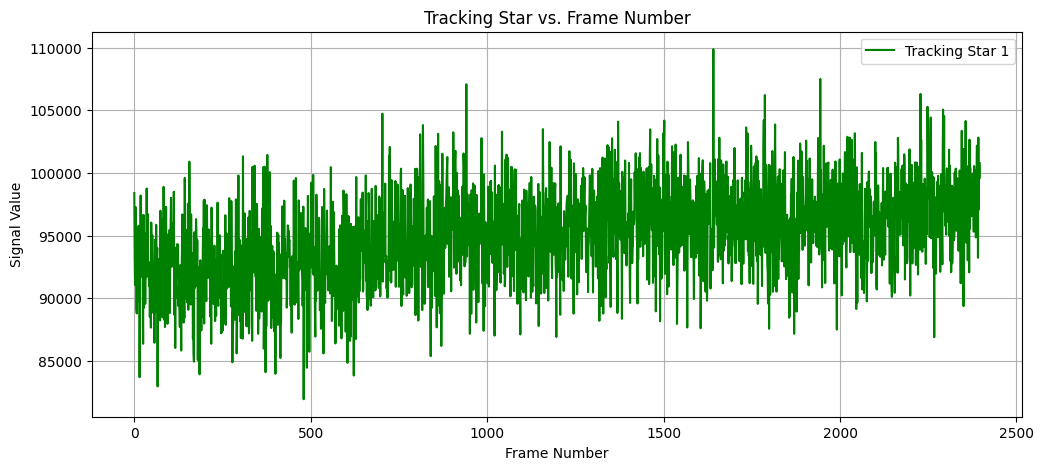

In [230]:
#@title Preview data
plt.figure(figsize=(12, 5))
plt.plot(x_orig, y_orig, color='blue', label='Signal (Target)')
plt.xlabel("Frame Number")
plt.ylabel("Signal Value")
plt.title("Target Signal vs. Frame Number")
plt.legend()
plt.grid(True)
plt.show()

# Second plot: track1_orig
plt.figure(figsize=(12, 5))
plt.plot(x_orig, track1_orig, color='green', label='Tracking Star 1')
plt.xlabel("Frame Number")
plt.ylabel("Signal Value")
plt.title("Tracking Star vs. Frame Number")
plt.legend()
plt.grid(True)
plt.show()

## STEP 2: Pick out spikes, scale data

In [231]:
#@title Remove spikes and irrelavent anomalies, load into working variables

std_target = np.std(y_orig)
mean_target = np.mean(y_orig)
target_thresh = mean_target + 4*std_target

std_track = np.std(track1_orig)
mean_track = np.mean(track1_orig)
track_thresh = mean_track + 4*std_track
x = []
y = []
t = []
track1 = []

for i in range(len(x_orig)):
    if y_orig[i] < target_thresh:
        x.append(x_orig[i])
        y.append(y_orig[i])
        track1.append(track1_orig[i])
        t.append(t_orig[i])

In [232]:
#@title Create working interval and scaled signal for easier processing
pred_interval = identify_interval(t, predicted_time, predicted_start, predicted_error, start_offset)
start, end = pred_interval
print("Interval frames: " + str(pred_interval))

y_scaled = data_shift_scale(y[pred_interval[0]:pred_interval[1]])

Interval frames: (1104, 1277)


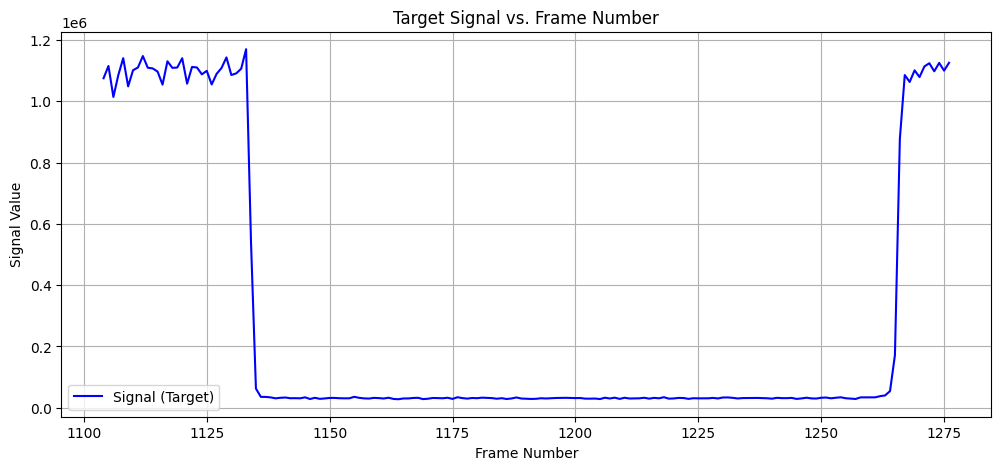

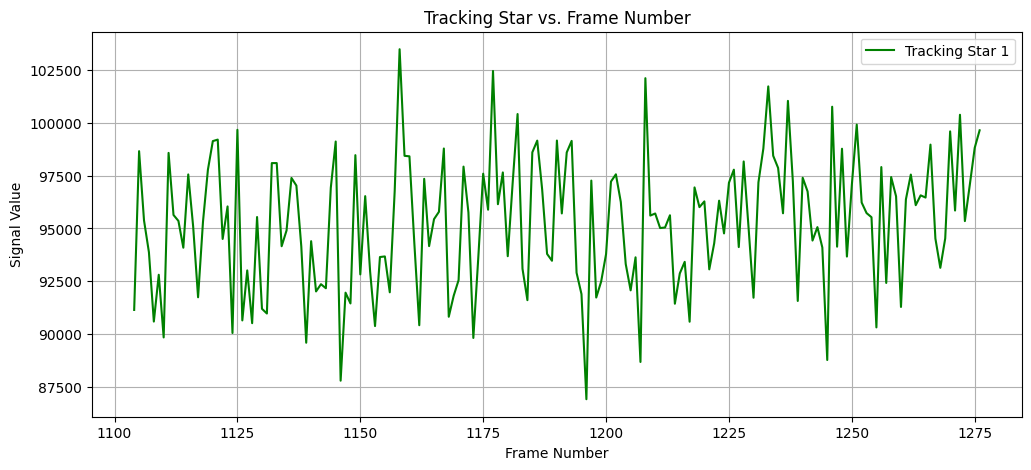

In [233]:
#@title Preview data
plt.figure(figsize=(12, 5))
plt.plot(x[pred_interval[0]:pred_interval[1]], y[pred_interval[0]:pred_interval[1]], color='blue', label='Signal (Target)')
plt.xlabel("Frame Number")
plt.ylabel("Signal Value")
plt.title("Target Signal vs. Frame Number")
plt.legend()
plt.grid(True)
plt.show()

# Second plot: track1_orig
plt.figure(figsize=(12, 5))
plt.plot(x[pred_interval[0]:pred_interval[1]], track1[pred_interval[0]:pred_interval[1]], color='green', label='Tracking Star 1')
plt.xlabel("Frame Number")
plt.ylabel("Signal Value")
plt.title("Tracking Star vs. Frame Number")
plt.legend()
plt.grid(True)
plt.show()

# First occultation check
## Perform analysis of target signal with tracking signal
The tracking star acts as a control to compare against the target signal. Noise, atmospheric phenomena, and anomalies will be consistant across both the target and tracking signal. If both signals are similar enough (Using Pearson correlation coefficient) around the predicted interval of occulation, do not proceed with further processing.

0.17858291382267777
There might be an occultation


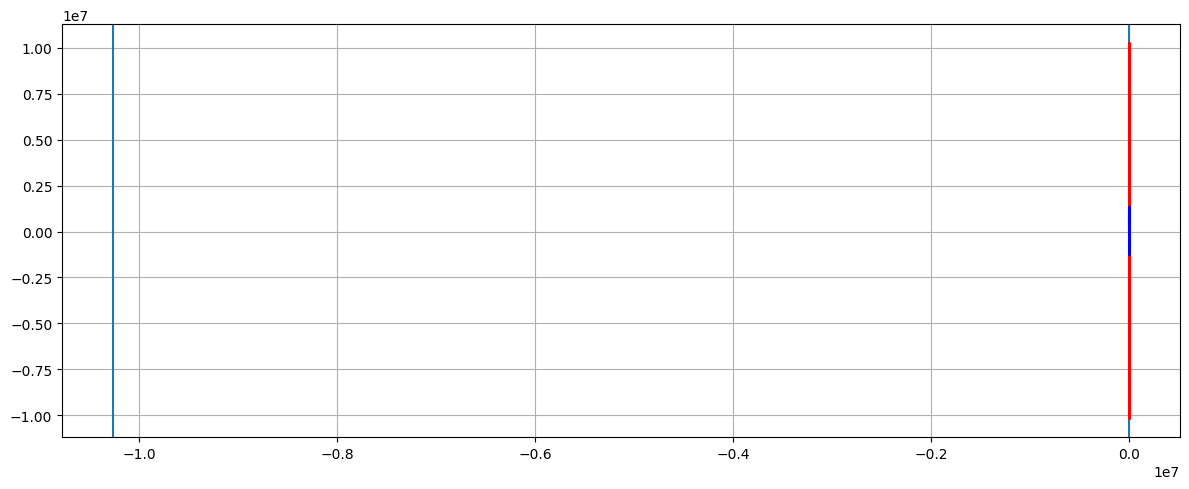

In [243]:
#@title Smooth
beta = 10 # @param {type:"raw"}
tracking_scaled = scale_to_match(y, track1, pred_interval)

target_filtered = betaFilter(y, beta)
tracking_filtered = betaFilter(tracking_scaled, beta)

r = check_correlation(target_filtered, tracking_filtered, pred_interval)

print(abs(r))

if abs(r) > 0.4:
  correlation = True
  print("Signals too simillar, NO OCCULTATION")
else:
  correlation = False
  print("There might be an occultation")


#plt.figure(figsize=(12, 5))

# plt.plot(x, y, label="Target (Raw)", color='steelblue', alpha=0.3)
# plt.plot(x, target_smooth, label="Target (Smoothed)", color='orange', linewidth=2)

# plt.plot(x, tracking_scaled, label="Tracking (Raw, Scaled)", color='green', alpha=0.3)
# plt.plot(x, tracking_smooth, label="Tracking (Smoothed)", color='firebrick', linewidth=2)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


plt.figure(figsize=(12, 5))


plt.axvline(x=min(target_filtered))
plt.axvline(x=pred_interval[1])

plt.plot(x[start:end], y[start:end], label="Target (Raw)", color='red', alpha=0.3)
plt.plot(x[start:end], target_smooth[start:end], label="Target (Smoothed)", color='red', linewidth=2)

plt.plot(x[start:end], tracking_scaled[start:end], label="Tracking (Raw, Scaled)", color='blue', alpha=0.3)
plt.plot(x[start:end], tracking_smooth[start:end], label="Tracking (Smoothed, Scaled)", color='blue', linewidth=2)
plt.grid(True)
plt.tight_layout()
plt.show()



# Second occultation check
## Perform Piecewise Viterbi algorithm to detect changes
Using concepts adjacent to Weak Continuity, we implement the Viterbi algorithm to find three piecewise constant steps representing the dip in signal. Fitting this dip is computationally expensive and only performed if correlation testing is inconclusive.

In [235]:
#@title Find step signal
if not(correlation) or override:
  y_piecewise = piecewise_constant_viterbi(y_scaled, int(np.max(y_scaled)))

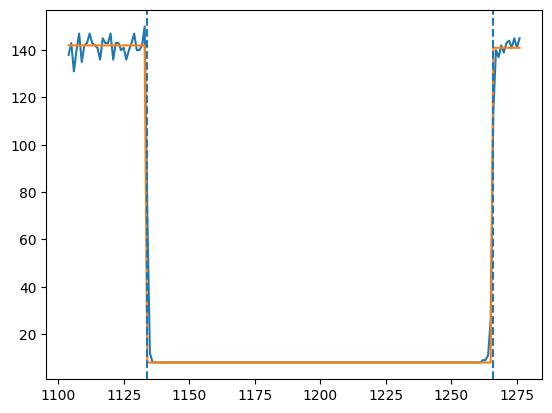

In [236]:
#@title Update signal graph and best fit step function
if not(correlation) or override:

  frames = change_frames(x[pred_interval[0]:pred_interval[1]], y_piecewise)
  total_frames = frames[1]-frames[0]

  times = getTimes(frames, t_orig)
  startTime_parsed = np.datetime64("2000-01-01T" + times[0].strip("[]"), 'ns')
  endTime_parsed = np.datetime64("2000-01-01T" + times[1].strip("[]"), 'ns')

  duration = endTime_parsed - startTime_parsed

  # Show plots
  plt.plot(x[pred_interval[0]:pred_interval[1]], y_scaled)
  plt.plot(x[pred_interval[0]:pred_interval[1]], y_piecewise)
  plt.axvline(x=frames[0], linestyle='--')
  plt.axvline(x=frames[1], linestyle='--')
  plt.show()

# FINAL RESULT

In [237]:
#@title Show occultation information
if override or ( not(correlation) and checkPos(y_piecewise) ) :
  print("Occultation Detected")
  print("\n")
  print("Start frame: \n" + str(frames[0]))
  print("\n")
  print("End frame: \n" + str(frames[1]))
  print("\n")
  print("Total frames dropped: \n" + str(total_frames))
  print("\n")
  print("Start time: \n" + str(times[0]))
  print("\n")
  print("End time: \n" + str(times[1]))
  print("\n")
  print("Occultation length: " + str(duration))
else:
  print("No Occultation")

33.5
Occultation Detected


Start frame: 
1134


End frame: 
1266


Total frames dropped: 
132


Start time: 
[04:22:39.1297240]


End time: 
[04:22:45.7394902]


Occultation length: 6609766200 nanoseconds


# DEBUGGING

In [238]:
print("Occultation Detected")
print("\n")
print("Start frame: \n" + str(frames[0]))
print("\n")
print("End frame: \n" + str(frames[1]))
print("\n")
print("Total frames dropped: \n" + str(total_frames))
print("\n")
print("Start time: \n" + str(times[0]))
print("\n")
print("End time: \n" + str(times[1]))
startTime_parsed = np.datetime64("2000-01-01T" + times[0].strip("[]"), 'ns')
endTime_parsed = np.datetime64("2000-01-01T" + times[1].strip("[]"), 'ns')
print("\n")
print("Occultation length: " + str(endTime_parsed - startTime_parsed))
print("\n")
for i in range(len(y_piecewise)):
  print("frame", i+pred_interval[0], "value", y_piecewise[i])

Occultation Detected


Start frame: 
1134


End frame: 
1266


Total frames dropped: 
132


Start time: 
[04:22:39.1297240]


End time: 
[04:22:45.7394902]


Occultation length: 6609766200 nanoseconds


frame 1104 value 142
frame 1105 value 142
frame 1106 value 142
frame 1107 value 142
frame 1108 value 142
frame 1109 value 142
frame 1110 value 142
frame 1111 value 142
frame 1112 value 142
frame 1113 value 142
frame 1114 value 142
frame 1115 value 142
frame 1116 value 142
frame 1117 value 142
frame 1118 value 142
frame 1119 value 142
frame 1120 value 142
frame 1121 value 142
frame 1122 value 142
frame 1123 value 142
frame 1124 value 142
frame 1125 value 142
frame 1126 value 142
frame 1127 value 142
frame 1128 value 142
frame 1129 value 142
frame 1130 value 142
frame 1131 value 142
frame 1132 value 142
frame 1133 value 142
frame 1134 value 8
frame 1135 value 8
frame 1136 value 8
frame 1137 value 8
frame 1138 value 8
frame 1139 value 8
frame 1140 value 8
frame 1141 value 8
frame 1142 valu